# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random, contextlib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, PReLU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from tensorflow.python.client import device_lib
import tensorflow as tf
print(tf.__version__)
print(device_lib.list_local_devices())
print(tf.config.list_physical_devices('GPU'))

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0=all, 1=info, 2=warning, 3=error
tf.get_logger().setLevel('ERROR')

from TreasureMaze import TreasureMaze
from GameExperience import GameExperience

%matplotlib inline

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

2.6.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14604204075726460012
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5706350592
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12556816086583988899
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
]
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 1.0

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


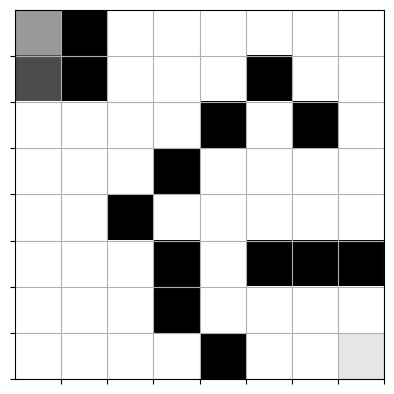

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, target_model, maze, **opt):
    
    # Exploration Factor
    global epsilon

    # Get parameters from opt
    n_epoch = opt.get('n_epoch', 15000)                         # Max epochs to train for
    max_memory = opt.get('max_memory', 1000)                    # Max experience memory buffer size
    data_size = opt.get('data_size', 256)                       # Max data size for training
    update_target_freq = opt.get('update_target_freq', 100)     # Number of epochs between each target_model sync

    start_time = datetime.datetime.now()

    # Initialize game enviromnent
    qmaze = TreasureMaze(maze)

    # Initialize experience replay with both models
    experience = GameExperience(model, target_model, max_memory=max_memory)

    win_history = []                # Array of every game played, 0 represents a loss and 1 represents a win
    hsize = qmaze.maze.size // 2    # History size used to determine exit condition
    win_rate = 0.0                  # Agent overall win rate

    # Initialize epsilon decay rate
    epsilon_max = 1.0       # Maximum epsilon value
    epsilon_min = 0.05      # Minimum epsilon value
    decay_period = 0.6      # Percentage of training run to decay over
    # Decay from max to min over 60% of the run
    epsilon_decay_rate = (epsilon_max - epsilon_min) / (n_epoch * decay_period)

    for epoch in range(n_epoch):

        # Initialize loss and n_episodes
        loss = 0.0
        n_episodes = 0

        # Randomly select a free cell
        agent_cell = random.choice(qmaze.free_cells)

        # Reset the maze with agent set to above position
        qmaze.reset(agent_cell)

        # Get current environment state
        envstate = qmaze.observe()

        # While the game is not over
        while qmaze.game_status() == "not_over":
            
            # Store previous environment state
            previous_envstate = envstate

            # Get action either through exploration or exploitation
            # If random is less than epsilon (chance to explore)
            if random.random() < epsilon:
                # Choose random action from current valid actions
                action = random.choice(qmaze.valid_actions())
            # Else predict next move given current environment state
            else:
                action = np.argmax(experience.predict(previous_envstate))

            # Get envstate, reward, and game status after action
            envstate, reward, game_status = qmaze.act(action)

            # Store episode in Experience replay object
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)

            # Increment number of episodes n_episodes
            n_episodes += 1

            # If game_status is "win", add win to history, else add loss
            if game_status == 'win':
                win_history.append(1)
            elif game_status == 'lose':
                win_history.append(0)

        # After the game ends, train main network model on batch from replay buffer
        inputs, targets = experience.get_data(data_size)
        loss = model.train_on_batch(inputs, targets)

        # Decay epsilon each epoch
        epsilon = max(0.05, epsilon - epsilon_decay_rate)

        # Sync target network every update_target_freq epochs
        if epoch % update_target_freq == 0:
            target_model.set_weights(model.get_weights())

        # win_rate is equal to sum of all wins divided by number of games played
        if len(win_history) > 0:
            win_rate = sum(win_history) / len(win_history)

        # Print the epoch, loss, episodes, win count, win rate, epsilon, and recent win history every 10 epochs
        if epoch % 10 == 0:
            dt = datetime.datetime.now() - start_time
            t = format_time(dt.total_seconds())
            template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {} | Epsilon: {:.3f} | Recent History: {}"
            print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t, epsilon, sum(win_history[-hsize:])))

        # If global win rate > 0.9, set epsilon to minimum value
        if win_rate > 0.9 and len(win_history) > 100:
            epsilon = 0.05

        # Completion check
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

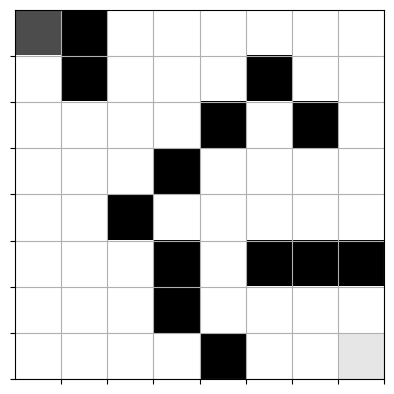

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
target_model = build_model(maze)
target_model.set_weights(model.get_weights())

qtrain(model, target_model, maze, n_epoch=3000, max_memory=10000, data_size=512)

Epoch: 000/2999 | Loss: 0.0518 | Episodes: 107 | Win count: 1 | Win rate: 1.000 | time: 1.8 seconds | Epsilon: 0.999 | Recent History: 1
Epoch: 010/2999 | Loss: 0.0074 | Episodes: 50 | Win count: 4 | Win rate: 0.364 | time: 3.7 seconds | Epsilon: 0.994 | Recent History: 4
Epoch: 020/2999 | Loss: 0.0044 | Episodes: 96 | Win count: 7 | Win rate: 0.333 | time: 5.4 seconds | Epsilon: 0.989 | Recent History: 7
Epoch: 030/2999 | Loss: 0.0019 | Episodes: 144 | Win count: 8 | Win rate: 0.258 | time: 7.3 seconds | Epsilon: 0.984 | Recent History: 8
Epoch: 040/2999 | Loss: 0.0033 | Episodes: 142 | Win count: 9 | Win rate: 0.220 | time: 9.5 seconds | Epsilon: 0.978 | Recent History: 7
Epoch: 050/2999 | Loss: 0.0018 | Episodes: 142 | Win count: 11 | Win rate: 0.216 | time: 12.0 seconds | Epsilon: 0.973 | Recent History: 5
Epoch: 060/2999 | Loss: 0.0025 | Episodes: 151 | Win count: 14 | Win rate: 0.230 | time: 14.9 seconds | Epsilon: 0.968 | Recent History: 6
Epoch: 070/2999 | Loss: 0.0017 | Episod

3923.165441

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

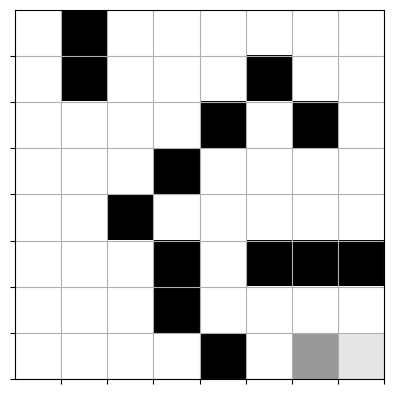

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

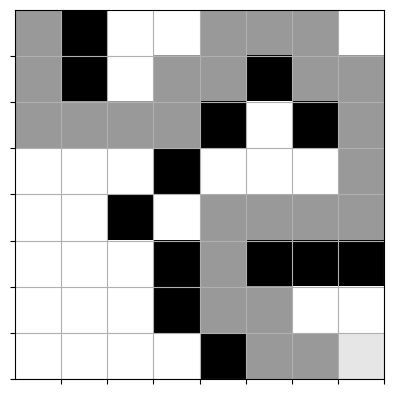

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.